# Estimate the response timescale for every glacier model and experiment (for the shifted simulations)

- response timescale estimated at mass shrinkage rates of -50%, -80% and -90%. The response timescales is only computed if at least 25% of the mass is lost (otherwise the noise is too large)...

The following file is created, which is later used in other notebooks for the analysis and visualisations:
`'../data/resp_time_shifted_X%_threshold25%_for_deltaT_rgi_reg_roll_volume_21yravg.csv'`

In [36]:

DATE = 'Feb12_2024' 
fill_option = 'repeat_last_101yrs'

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

approach = '_via_5yravg'


# the non-shifted stuff is just read in for some tests ... 
path_merged_runs_scaled_extend = f'../data/GMIP3_reg_glacier_model_data/glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}.nc'
ds_reg_models_extend = xr.open_dataset(path_merged_runs_scaled_extend)
ds_reg_yr_shift= xr.open_dataset(f'../data/GMIP3_reg_glacier_model_data/all_shifted_glacierMIP3_{DATE}_models_all_rgi_regions_sum_scaled_extended_{fill_option}{approach}.nc')

# only select final submission data
glac_models = ['CISM2', 'GO', 'PyGEM-OGGM_v13', 'GloGEMflow', 'Kraaijenbrink', 'GLIMB','OGGM_v16', 'GloGEMflow3D']
ds_reg_models_extend = ds_reg_models_extend.sel(model_author = glac_models)
ds_reg_yr_shift = ds_reg_yr_shift.sel(model_author = glac_models)

def get_glob_temp_exp(region='global'):
    pd_global_temp_exp_glac = pd.read_csv(f'../data/climate_input_data/temp_ch_ipcc_ar6_isimip3b_glacier_regionally.csv', index_col = 0)
    _p = pd_global_temp_exp_glac.loc[pd_global_temp_exp_glac.region == region]
    _p = _p.groupby(['gcm','period_scenario']).mean('temp_ch_ipcc')
    return _p

pd_global_temp_exp_m = get_glob_temp_exp(region='global')

In [37]:
global_models = ds_reg_models_extend.sel(simulation_year=0).dropna(dim='model_author',how='any').model_author.values

In [38]:
def resp_time_estimate(model_author='OGGM_v16', perc_change_l=[-50],
                       rgi_reg='11', min_perc_change=25, roll_volume=21, shift_years=False):
    # computes the response timescale estimates for all 80 experiments of a given model_author and rgi_reg 
    # perc_change : -50 (gives estimates of how fast 50% of total volume change occurs), also -80 is used in the manuscript
    # min_perc_change: minimum shrinkage/growing to estimate a "response time" (%)
    # HERE, the first occurrence of -50% change over the roll_volume avg. is used, 
    # alternatively we could use the last occurrence, but this would "mean" something different of course ... 
    # we also select the equilibrium volume by averaging over the last 100 years,
    # this is necessary due to the large interdecadal variability of some models
    # MAYBE could even select there 200 or 300 years (but then we would also need to check how the data is "extended"...
    if shift_years:
        # we shift by maximum by +50 years, so like that there should always be values inside 
        _ds_reg_models_extend = ds_reg_yr_shift.sel(year_after_2020=slice(0,4950))
    else:
        _ds_reg_models_extend = ds_reg_models_extend
    if rgi_reg == 'All':
        if model_author in global_models:
            ds_reg_models_vol_all = _ds_reg_models_extend.volume_m3.sum(dim='rgi_reg')
        else:
            raise Exception("not a global model!!!")
    
    else:
        ds_reg_models_vol_all = _ds_reg_models_extend.volume_m3.sel(rgi_reg=rgi_reg) # need to do the interpolation first !

    ds_reg_models_vol_all = ds_reg_models_vol_all.stack(experiments=['gcm','period_scenario'])
    # merge "gcm"s and "period_scenario" into one coordinate callled "experiments"
    ds_reg_models_vol_all = ds_reg_models_vol_all.assign_coords(temp_ch_ipcc = ('experiments',
                                                                      pd_global_temp_exp_m.loc[ds_reg_models_vol_all.experiments, 
                                                                                               'temp_ch_ipcc']))
    ds_reg_models_sel_vol_all = ds_reg_models_vol_all.sel(model_author=model_author)
    # steady state is the average of the last 100 years!!!
    if shift_years:
        v_eq = ds_reg_models_sel_vol_all.sel(year_after_2020=slice(4901-50,5000-50)).mean(dim='year_after_2020')
        v0 = ds_reg_models_sel_vol_all.sel(year_after_2020=0) 
    else:
        v_eq = ds_reg_models_sel_vol_all.sel(simulation_year=slice(4901,5000)).mean(dim='simulation_year')
        v0 = ds_reg_models_sel_vol_all.isel(simulation_year=0)
    
    pd_category_resp_time = pd.DataFrame(index=ds_reg_models_vol_all.experiments)
    if rgi_reg == 'All':
        pd_category_resp_time['rgi_reg'] = f'All'
    else:
        pd_category_resp_time['rgi_reg'] = f'RGI{rgi_reg}'
    pd_category_resp_time['model_author'] = model_author
    pd_category_resp_time['min_perc_change'] = min_perc_change

    pd_category_resp_time.loc[ds_reg_models_vol_all.experiments, 'temp_ch_ipcc']  = ds_reg_models_vol_all.temp_ch_ipcc.values
    # did it grow, shrink or stay the same??? ... this information is later not anymore used
    pd_category_resp_time['category'] = r'similar to V$_{0}$'
    grow_exps = v_eq.where(v_eq/v0 >=1+min_perc_change/100, drop=True).experiments.values
    pd_category_resp_time.loc[grow_exps, 'category'] = 'grow'
    shrink_exps = v_eq.where(v_eq/v0 <=1-min_perc_change/100, drop=True).experiments.values
    pd_category_resp_time.loc[shrink_exps, 'category'] = 'shrink'
    pd_category_resp_time['shift_years'] = shift_years
    for perc_change in perc_change_l:
        # response time computation
        # V(resp_t) = -perc/100 * (V_eq-v0)+v0)
        # we need the absolute because we only want to have either shrinking (negative perc) 
        # or growing (positive perc) experiments
        v_resp_t = v0 + (perc_change/100)*np.abs(v0-v_eq)
        if shift_years:
            v_roll = ds_reg_models_sel_vol_all.rolling(year_after_2020=roll_volume, center=True).mean()
            # we take the last year where the anti-condition holds true (so it is basically the first year where the condition holds true)
            resp_t = v_roll.where(v_roll<=v_resp_t).idxmax(dim='year_after_2020')
            #print(v_roll, resp_t)
        else:
            v_roll = ds_reg_models_sel_vol_all.rolling(simulation_year=roll_volume, center=True).mean()
            # we take the last year where the anti-condition holds true (so it is basically the first year where the condition holds true)
            resp_t = v_roll.where(v_roll<=v_resp_t).idxmax(dim='simulation_year')
        if perc_change<0:
            # if we look at how much it shrinks it should at least shrink by min_perc_change to estimate a "response time"
            resp_t = resp_t.where(v_eq/v0 <=1-min_perc_change/100, np.NaN)
        else:
            # if we look at how much it grows it should at least grow by min_perc_change to estimate a "response time"
            resp_t = resp_t.where(v_eq/v0 >=1+min_perc_change/100, np.NaN)
        if perc_change>0:
            perc_change_i = f'+{perc_change}'
        else:
            perc_change_i = perc_change
        pd_category_resp_time.loc[resp_t.experiments,f'resp_time_{perc_change_i}%'] = resp_t.values
    
    return pd_category_resp_time

just some random response timescale test estimates ... with and without shifting the experiments to start in year 2020...

In [39]:
resp_time_estimate(model_author='GLIMB', rgi_reg='All')

,rgi_reg,model_author,min_perc_change,temp_ch_ipcc,category,shift_years,resp_time_-50%
"(gfdl-esm4, 1851-1870_hist)",All,GLIMB,25,0.231409,similar to V$_{0}$,False,NaN
"(gfdl-esm4, 1901-1920_hist)",All,GLIMB,25,0.478289,shrink,False,346.0
"(gfdl-esm4, 1951-1970_hist)",All,GLIMB,25,0.392281,shrink,False,370.0
"(gfdl-esm4, 1995-2014_hist)",All,GLIMB,25,0.901467,shrink,False,284.0
"(gfdl-esm4, 2021-2040_ssp126)",All,GLIMB,25,1.493792,shrink,False,237.0
...,...,...,...,...,...,...,...
"(ukesm1-0-ll, 2061-2080_ssp370)",All,GLIMB,25,4.439977,shrink,False,72.0
"(ukesm1-0-ll, 2061-2080_ssp585)",All,GLIMB,25,5.230543,shrink,False,59.0
"(ukesm1-0-ll, 2081-2100_ssp126)",All,GLIMB,25,3.038482,shrink,False,99.0
"(ukesm1-0-ll, 2081-2100_ssp370)",All,GLIMB,25,5.840495,shrink,False,51.0


<AxesSubplot:xlabel='temp_ch_ipcc', ylabel='resp_time_-50%'>

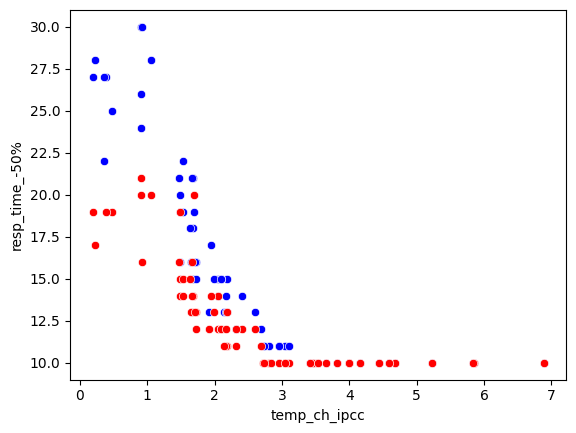

In [40]:
rgi_reg='11'
m = 'PyGEM-OGGM_v13'
perc=-50
_r_no_shift = resp_time_estimate(model_author=m, perc_change_l=[perc],
                   rgi_reg=rgi_reg, min_perc_change=25, shift_years=False)
_r_w_shift = resp_time_estimate(model_author=m, perc_change_l=[perc],
                   rgi_reg=rgi_reg, min_perc_change=25, shift_years=True)
sns.scatterplot(data=_r_no_shift.dropna(),
                x='temp_ch_ipcc', y=f'resp_time_{perc}%', color='blue')
sns.scatterplot(data=_r_w_shift.dropna(),
                x='temp_ch_ipcc', y=f'resp_time_{perc}%', color='red')

- it makes sense that the response timescale is shorter for 2020 as the glaciers retreated to higher altitudes, where they are likely steeper and thus respond in general faster ... 

some previous tests showed (removed core here to not have too much code):
- only when we set a threshold of how much volume loss has to occur, we get response timescales that are not totally noisy 
    - much less noise, when choosing min_perc_change=25, instead of min_perc_change=10, however,it also results in more models where no response timescale can be estimated, which is not good. 

**test: check that the correct volume loss occurs at the computed response timescale**


In [41]:
rgi_regs = []
for rgi_reg in np.arange(1,20,1):
    if rgi_reg < 10:
        rgi_reg = '0'+str(rgi_reg)
    else:
        rgi_reg = str(rgi_reg)
    rgi_regs.append(rgi_reg)

for model_author in ['OGGM_v16', 'GLIMB']: ## just select two random models to test
    for rgi_reg in rgi_regs:
        pd_test = resp_time_estimate(model_author=model_author, perc_change_l=[-50],
                                     roll_volume=21,
                           rgi_reg=rgi_reg, min_perc_change=25)
        pd_test = pd_test.dropna()
        pd_test = pd_test.loc[pd_test.temp_ch_ipcc>1.2]

        for j,ind in enumerate(pd_test.index):
            ds_test = ds_reg_models_extend.volume_m3.sel(model_author=model_author, rgi_reg=rgi_reg).stack(experiments=['gcm','period_scenario']).sel(experiments=pd_test.index[j])
            ds_init = ds_test[0].values
            ds_test = ds_test.rolling(simulation_year=21, center=True).mean()
            response_timescale = pd_test.iloc[j]['resp_time_-50%'] 
            # test works only if the response timescale is long enough, as otherwise issues due to fast changes and rolling averages
            if response_timescale>20:
                vol_change_at_resp_time_yr = ds_init-ds_test.sel(simulation_year = response_timescale).values
                
                # total volume change
                vol_change_total = ds_init-ds_test[-11]
                # is the volume change at response timescale year 50% of the total change? 
                # it does not have to match perfectly as a lot happens in between specifically for small response timescales
                np.testing.assert_allclose(vol_change_at_resp_time_yr, 0.5*vol_change_total, rtol=0.05)
                

In [42]:
pd_test = resp_time_estimate(model_author='GO', perc_change_l=[-50],
                           rgi_reg='06', min_perc_change=25)
pd_test.dropna().min(), pd_test.dropna().max()

(rgi_reg               RGI06
 model_author             GO
 min_perc_change          25
 temp_ch_ipcc       0.901467
 category             shrink
 shift_years           False
 resp_time_-50%         10.0
 dtype: object,
 rgi_reg               RGI06
 model_author             GO
 min_perc_change          25
 temp_ch_ipcc       6.884361
 category             shrink
 shift_years           False
 resp_time_-50%         23.0
 dtype: object)

In [43]:
shift_years = True
rgi_regs_global = ['All', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12',
                   '13', '14', '15', '16', '17', '18', '19']

if shift_years:
    # we shift by maximum by +50 years, so like that there should always be values inside 
    _ds_reg_models_extend = ds_reg_yr_shift.sel(year_after_2020=slice(0,4950))
    xx = 'year_after_2020'
    pd_reg_models_count = _ds_reg_models_extend.volume_m3.sel(year_after_2020=0).to_dataframe().groupby(['rgi_reg', 'model_author'])['volume_m3'].count().reset_index()
    p_add = '_shifted'
    lab_add = 'after 2020 '

else:
    _ds_reg_models_extend = ds_reg_models_extend
    xx = 'simulation_year'
    pd_reg_models_count = _ds_reg_models_extend.volume_m3.sel(simulation_year=0).to_dataframe().groupby(['rgi_reg', 'model_author'])['volume_m3'].count().reset_index()
    p_add = ''
    lab_add = ''

## rolling mean to estimate the response time scale.. 
roll_volume=21 
# assume that at least 25% change is necessary to estimate a "response timescale"
min_perc_change = 25  # also tested: 1,5,10,20,

In [29]:
pd_reg_models_count

,rgi_reg,model_author,volume_m3
0,01,CISM2,0
1,01,GLIMB,80
2,01,GO,0
3,01,GloGEMflow,80
4,01,GloGEMflow3D,0
...,...,...,...
147,19,GloGEMflow,80
148,19,GloGEMflow3D,0
149,19,Kraaijenbrink,0
150,19,OGGM_v16,80


In [44]:

pd_reg_models_count = pd_reg_models_count.loc[pd_reg_models_count.rgi_reg !='All']
pd_reg_models_count = pd_reg_models_count.rename(columns={'volume_m3':'n_experiments'})
# models available for each region...
_regional_model = pd_reg_models_count.loc[pd_reg_models_count.n_experiments > 0 ] # ==80

## amount of models per region
# at least 1 experiment for that RGI region
reg_n_models = pd_reg_models_count.loc[pd_reg_models_count.n_experiments > 0].groupby('rgi_reg').count()['model_author'] 
# models that are globally available 
max_exps=pd_reg_models_count.n_experiments.max()
global_models = pd_reg_models_count.groupby('model_author').sum().where(pd_reg_models_count.groupby('model_author').sum().n_experiments == 19 * max_exps).dropna().index

pd_category_resp_time_l = []
for perc in [-50,-80,-90]: 
    for j, rgi_reg in enumerate(rgi_regs_global):
        if rgi_reg == 'All':
            # only take models that exist globally
            # at the moment Rounce, Glimb, OGGM,GloGEMflow
            n = len(global_models)
            mj = 0
            for m in glac_models:
                if m in global_models:
                    mj+=1
                    pd_category_resp_time = resp_time_estimate(model_author=m, perc_change_l=[perc],
                       rgi_reg=rgi_reg, min_perc_change=min_perc_change,
                                                              roll_volume=roll_volume,shift_years=shift_years)
                    pd_category_resp_time_l.append(pd_category_resp_time)
                else:
                    pass

        else:    
            models_available = _regional_model.loc[_regional_model.rgi_reg==rgi_reg]['model_author'].values
            n = reg_n_models[rgi_reg]
            mj=0
            for m in glac_models:
                if m in models_available:
                    mj+=1
                    
                    pd_category_resp_time = resp_time_estimate(model_author=m, perc_change_l=[perc],
                                                               rgi_reg=rgi_reg, min_perc_change=min_perc_change,
                                                              roll_volume=roll_volume,shift_years=shift_years)
                    pd_category_resp_time_l.append(pd_category_resp_time)

pd_response_time_x_perc_loss = pd.concat(pd_category_resp_time_l)
# just some reformatting (no real averaging...)
pd_response_time_x_perc_loss_comp = pd_response_time_x_perc_loss.copy().drop(columns=['category','shift_years']) # loc[pd_response_time_x_perc_loss.rgi_reg !='All']
pd_response_time_x_perc_loss_comp = pd_response_time_x_perc_loss_comp.reset_index(names=['gcm_period_scenario'])
# Convert the string representations of tuples into actual tuples
tuple_list = [eval(str(item)) for item in list(pd_response_time_x_perc_loss_comp['gcm_period_scenario'].values)]
# Create a new list in 'gcm_period_scenario' format
reformatted_list = [f"{gcm}_{period_scenario}" for gcm, period_scenario in tuple_list]
pd_response_time_x_perc_loss_comp['gcm_period_scenario'] = reformatted_list
pd_response_time_x_perc_loss_comp = pd_response_time_x_perc_loss_comp.groupby(['rgi_reg', 'model_author', 'temp_ch_ipcc','gcm_period_scenario']).mean()
ds_response_time_x_perc_loss_comp = pd_response_time_x_perc_loss_comp.to_xarray()

# this is the difference to the median glacier model 
for p in [-50,-80,-90]:
    ds_response_time_x_perc_loss_comp[f'diff_resp_time_{p}%'] = ds_response_time_x_perc_loss_comp[f'resp_time_{p}%'] - ds_response_time_x_perc_loss_comp[f'resp_time_{p}%'].median(dim='model_author') 

pd_response_time_x_perc_loss_comp = ds_response_time_x_perc_loss_comp.to_dataframe().reset_index()
pd_response_time_x_perc_loss_comp = pd_response_time_x_perc_loss_comp.dropna()

# create "classes" of global temp. change <--- not anymore used ... 
#T0_l, T1_l = [], []
#temp_labels = []
#for t0, t1 in zip([min_t_r, 2, 4],[2, 4, max_t_r]):
#    temp_label = f'{t0:.1f}°C-{t1:.1f}°C'
#    condi = (pd_response_time_x_perc_loss_comp.temp_ch_ipcc <=t1)&(pd_response_time_x_perc_loss_comp.temp_ch_ipcc >=t0)
#    temp_labels_length_l = len(pd_response_time_x_perc_loss_comp.loc[condi].groupby('temp_ch_ipcc').count())
#    pd_response_time_x_perc_loss_comp.loc[condi, 'temp_ch_classes'] = temp_label + f' (n={temp_labels_length_l})'
# for the summary plot using the K-means clustering in 3_fitted_glacier_response.... 

pd_response_time_x_perc_loss_comp['min_perc_change'] =min_perc_change
pd_response_time_x_perc_loss_comp.reset_index(drop=True).to_csv(f'../data/resp_time{p_add}_X%_threshold{min_perc_change}%_for_deltaT_rgi_reg_roll_volume_{roll_volume}yravg.csv')

In [49]:
pd_response_time_x_perc_loss_comp.reset_index(drop=True)

,rgi_reg,model_author,temp_ch_ipcc,gcm_period_scenario,min_perc_change,resp_time_-50%,resp_time_-80%,resp_time_-90%,diff_resp_time_-50%,diff_resp_time_-80%,diff_resp_time_-90%
0,All,GLIMB,0.302892,ipsl-cm6a-lr_1951-1970_hist,25,420.0,1138.0,1785.0,88.0,208.0,282.5
1,All,GLIMB,0.478289,gfdl-esm4_1901-1920_hist,25,382.0,1152.0,1877.0,87.0,260.5,397.5
2,All,GLIMB,0.901467,gfdl-esm4_1995-2014_hist,25,312.0,1001.0,1660.0,122.0,440.0,720.0
3,All,GLIMB,0.904940,mpi-esm1-2-hr_1995-2014_hist,25,329.0,1032.0,1763.0,148.0,511.0,888.0
4,All,GLIMB,0.913313,ipsl-cm6a-lr_1995-2014_hist,25,307.0,966.0,1597.0,135.0,483.0,781.0
...,...,...,...,...,...,...,...,...,...,...,...
6010,RGI19,PyGEM-OGGM_v13,4.677751,ipsl-cm6a-lr_2081-2100_ssp370,25,123.0,275.0,374.0,22.0,25.0,-38.0
6011,RGI19,PyGEM-OGGM_v13,5.230543,ukesm1-0-ll_2061-2080_ssp585,25,116.0,267.0,377.0,30.0,40.5,10.0
6012,RGI19,PyGEM-OGGM_v13,5.840495,ukesm1-0-ll_2081-2100_ssp370,25,69.0,158.0,223.0,17.5,30.0,31.0
6013,RGI19,PyGEM-OGGM_v13,5.849305,ipsl-cm6a-lr_2081-2100_ssp585,25,93.0,204.0,277.0,18.0,34.5,37.5
